In [94]:
import requests
import io
import zipfile
import pandas as pd
import functools
import math
import numpy as np

In [29]:
urls = {
    'metric_monthly': 'http://www.psmsl.org/data/obtaining/met.monthly.data/met_monthly.zip',
}
dataset_name = 'metric_monthly'
dataset_name_compact = 'met_monthly'

In [30]:
# The names of the stations of interest
main_stations = {
    20: {
        'name': 'Vlissingen'
    },
    22: {
        'name': 'Hoek van Holland'
    },
    23: {
        'name': 'Den Helder'
    },
    24: {
        'name': 'Delfzijl'
    },
    25: {
        'name': 'Harlingen'
    },
    32: {
        'name': 'IJmuiden'
    }
}

In [114]:
# the main stations are defined by their ids
main_stations_idx = list(main_stations.keys())
#main_stations_idx

In [115]:
# download the zipfile
resp = requests.get(urls[dataset_name])

# we can read the zipfile
stream = io.BytesIO(resp.content)
zf = zipfile.ZipFile(stream)

# this list contains a table of 
# station ID, latitude, longitude, station name, coastline code, station code, and quality flag
csvtext = zf.read('{}/filelist.txt'.format(dataset_name_compact))

stations = pd.read_csv(
    io.BytesIO(csvtext), 
    sep=';',
    names=('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality'),
    converters={
        'name': str.strip,
        'quality': str.strip
    }
)
stations = stations.set_index('id')

# the dutch stations in the PSMSL database, make a copy
# or use stations.coastline_code == 150 for all dutch stations
selected_stations = stations.loc[main_stations_idx].copy()
# set the main stations, this should be a list of 6 stations
#selected_stations

In [116]:
# each station has a number of files that you can look at.
# here we define a template for each filename

# stations that we are using for our computation
# define the name formats for the relevant files
names = {
    #'datum': '{dataset}/RLR_info/{id}.txt',
    #'diagram': '{dataset}/RLR_info/{id}.png',
    'url': 'http://www.psmsl.org/data/obtaining/rlr.diagrams/{id}.php',
    'data': '{dataset}/data/{id}.metdata',
    #'doc': '{dataset}/docu/{id}.txt',
    #'contact': '{dataset}/docu/{id}_auth.txt'
}

In [117]:
def get_url(station, dataset):
    """return the url of the station information (diagram and datum)"""
    info = dict(
        dataset=dataset,
        id=station.name
    )
    url = names['url'].format(**info)
    return url
# fill in the dataset parameter using the global dataset_name
f = functools.partial(get_url, dataset=dataset_name)
# compute the url for each station
selected_stations['url'] = selected_stations.apply(f, axis=1)
#selected_stations

Need some functions to check for missing values and to retrieve the data from the zipfile.

In [118]:
def missing2nan(value, missing=-99999):
    """convert the value to nan if the float of value equals the missing value"""
    value = float(value)
    if value == missing:
        return np.nan
    return value

def get_data(station, dataset):
    """get data for the station (pandas record) from the dataset (url)"""
    info = dict(
        dataset=dataset,
        id=station.name
    )
    bytes = zf.read(names['data'].format(**info))
    df = pd.read_csv(
        io.BytesIO(bytes), 
        sep=';', 
        names=('year', 'height', 'interpolated', 'flags')
#         converters={
#             "height": lambda x: main_stations[station.name](missing2nan(x)),
#             "interpolated": str.strip,
#         }
    )
    df['station'] = station.name
    return df

In [119]:
def convertdecimalyear2datetime(x_months):
    x_month_datetime = []
    for month in x_months:
        dmonth, year = math.modf(month)
        x_month_datetime.append(pd.datetime(int(year),int(np.ceil(dmonth*12)),15))
    x_months_series = pd.Series(x_month_datetime)
    return x_months_series

In [120]:
# get data for all stations
f = functools.partial(get_data, dataset=dataset_name_compact)
# look up the data for each station
selected_stations['data'] = [f(station) for _, station in selected_stations.iterrows()]

In [121]:
# we now have data for each station
#selected_stations[['name', 'data']]

Create concatenated dataframe of all locations with all waterlevels in cm+NAP for all months recorded at PSMSL and return as dataframe accessible in 'paired difference analysis RWS and PSMSL'

In [122]:
df_psmsl = pd.DataFrame()
for station in selected_stations.iterrows():
    loc_name = station[1]['name']
    x_months = station[1]['data']['year']
    y_height = station[1]['data']['height']    

    # The daily, monthly and annual heights are expressed in millimetres. 
    # The dates are in decimal years (centred on the 15th day of the month for monthly values and at midday for daily values).
    y_height /= 10 # to get centimeters
    x_months = convertdecimalyear2datetime(x_months)
    
    df_loc = pd.DataFrame(data=y_height.as_matrix(), index=x_months, columns=[loc_name+'_'+'WATHTE_cmNAP'])
    df_psmsl = pd.concat((df_psmsl,df_loc), axis=1)

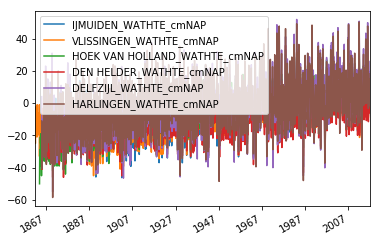

In [123]:
%matplotlib inline
df_psmsl.plot()